# 06. Временные ряды

Содержание:
- Временные ряды
- Пример
- Методы прогнозирования
- Дополнительные темы для дальнейшего изучения

# 1. Временные ряды: основные понятия

**Временной ряд** $-$ это последовательность данных или измерений, собранных в последовательные моменты времени через равные промежутки. Каждая единица данных называется "измерением" или "отсчётом". Проще говоря, если вы каждый день в одно и то же время записываете температуру за окном $-$ вы формируете временной ряд.

Примеры временных рядов в реальной жизни:
- Ежедневные котировки акций компаний
- Измерения температуры и влажности воздуха
- Данные о продажах магазина
- Статистика посещаемости веб-сайта

### Сезонность и тренд

**Тренд** $-$ это общая направленность ряда, долгосрочное увеличение или уменьшение значений. Например, постепенный рост средних температур из-за изменения климата.

**Сезонность** $-$ это периодические колебания, которые повторяются с определённой частотой. Например, повышение продаж мороженого каждое лето.

На практике временной ряд часто раскладывают на три компоненты:
$$ Y(t) = S(t) + T(t) + R(t),$$
где
- $S(t)$ $-$ сезонная компонента,
- $T(t)$ $-$ тренд,
- $R(t)$ $-$  остаток.
  
## Стационарный и нестационарный ряд

**Стационарный временной ряд** $-$ это ряд, статистические свойства которого (среднее значение, дисперсия) не меняются с течением времени. У стационарного ряда:
- Отсутствует тренд (общая направленность вверх или вниз)
- Отсутствует сезонность (периодические колебания)
- Не изменяется дисперсия (разброс значений относительно среднего)

**Нестационарный ряд** $-$ это ряд, у которого есть тренд, сезонность или меняющаяся дисперсия.

# 2. Пример: анализ временного ряда погоды

## Генерация данных

Сгенерируем синтетические данные о погоде с двумя признаками: температура и влажность.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Настройка случайного генератора для воспроизводимости
np.random.seed(42)

# Создание временной шкалы (~5 лет)
m = 365*5
dates = pd.date_range(start='2000-04-01', periods=m, freq='D')

# Генерация температуры с трендом и сезонностью
t = np.arange(m)
trend = 0.002 * t  # небольшой восходящий тренд (потепление)
seasonality = 10 * np.sin(2 * np.pi * t / 365)  # годовая сезонность
noise = np.random.normal(0, 1, m)
temperature = -5 + trend + seasonality + noise  # базовая температура -5°C

# Генерация влажности (обратная зависимость от температуры)
humidity = 60 - 0.3 * temperature + np.random.normal(0, 5, m)

# Создание DataFrame
weather_data = pd.DataFrame({
    'date': dates,
    'temperature': temperature,
    'humidity': humidity
})
weather_data.set_index('date', inplace=True)

## Визуализация и анализ ряда

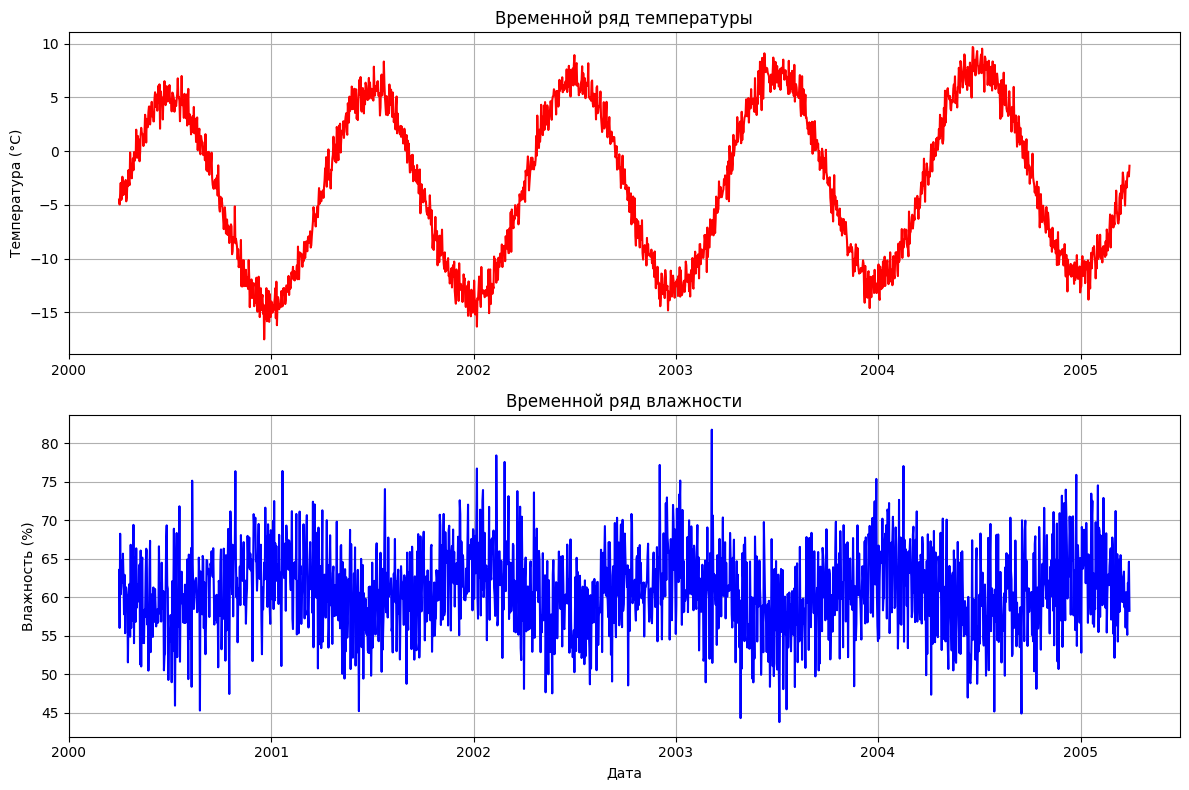

In [2]:
# Визуализация временных рядов
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# График температуры
ax1.plot(weather_data.index, weather_data['temperature'], color='red')
ax1.set_ylabel('Температура (°C)')
ax1.set_title('Временной ряд температуры')
ax1.grid(True)

# График влажности
ax2.plot(weather_data.index, weather_data['humidity'], color='blue')
ax2.set_ylabel('Влажность (%)')
ax2.set_xlabel('Дата')
ax2.set_title('Временной ряд влажности')
ax2.grid(True)

plt.tight_layout()
plt.show()

## Свойства ряда

In [3]:
# Проверка стационарности
from statsmodels.tsa.stattools import adfuller

# Для проверки стационарности используется тест Дики-Фуллера. Если p-value этого теста меньше 0.05, ряд считается стационарным
def check_stationarity(series, name):
    result = adfuller(series.dropna())
    print(f'{name}: p-value = {result[1]:.4f}', end=' - ')
    if result[1] < 0.05:
        print('ряд стационарен')
    else:
        print('ряд нестационарен')

check_stationarity(weather_data['temperature'], 'Температура')
check_stationarity(weather_data['humidity'], 'Влажность')

# Вычисление основных статистик
print(f"\nСтатистики температуры:")
print(f"Среднее: {weather_data['temperature'].mean():.2f}°C")
print(f"Стандартное отклонение: {weather_data['temperature'].std():.2f}°C")
print(f"Минимальное значение: {weather_data['temperature'].min():.2f}°C")
print(f"Максимальное значение: {weather_data['temperature'].max():.2f}°C")

print(f"\nСтатистики влажности:")
print(f"Среднее: {weather_data['humidity'].mean():.2f}%")
print(f"Стандартное отклонение: {weather_data['humidity'].std():.2f}%")

Температура: p-value = 0.0000 - ряд стационарен
Влажность: p-value = 0.0044 - ряд стационарен

Статистики температуры:
Среднее: -3.13°C
Стандартное отклонение: 7.04°C
Минимальное значение: -17.51°C
Максимальное значение: 9.70°C

Статистики влажности:
Среднее: 60.98%
Стандартное отклонение: 5.40%


## Выявление тренда и сезонности

[seasonal_decompose](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) выполняет декомпозицию временного ряда на три компоненты:
- Тренд (trend) - долгосрочная направленность
- Сезонность (seasonal) - периодические колебания
- Остаток (residual) - случайные отклонения

`model='additive'`: используемая модель. Аддитивная модель предполагает, что временной ряд представляется в виде:
$$y(t) = trend + seasonal + residual$$

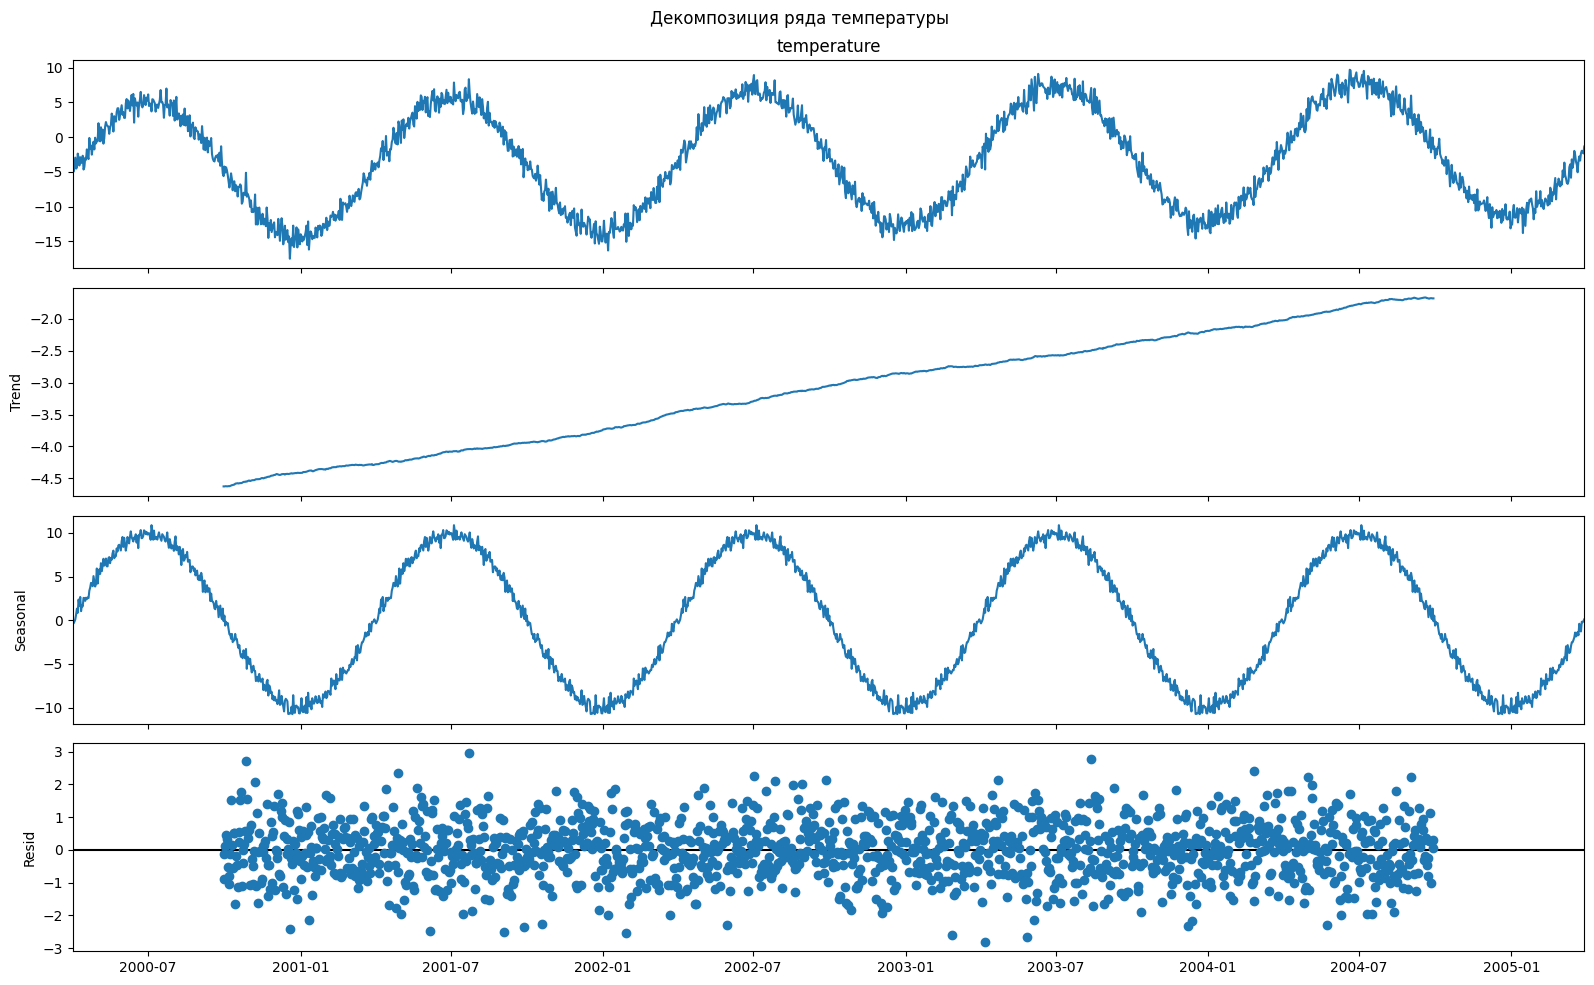

In [4]:
# Декомпозиция ряда температуры
from statsmodels.tsa.seasonal import seasonal_decompose

#decomposition = seasonal_decompose(weather_data['temperature'].iloc[:365], model='additive', period=30)
decomposition = seasonal_decompose(weather_data['temperature'], model='additive', period=365)
fig = decomposition.plot()
fig.set_size_inches(16, 10)
plt.suptitle('Декомпозиция ряда температуры')
plt.tight_layout()
plt.show()

# 3. Методы прогнозирования: наивные методы

**Наивный прогноз** $-$ простейший метод прогнозирования, где будущее значение принимается равным последнему наблюдаемому значению: $Y(t+h|t) = Y(t)$

**Сезонно-наивный прогноз** учитывает сезонность: $Y(t+h|t) = Y(t+h-T)$, где $T$ $-$ период сезонности.

In [5]:
# Разделение на обучающую и тестовую выборки
train_size = int(len(weather_data) * 0.9)
train = weather_data.iloc[:train_size]
test = weather_data.iloc[train_size:]

# Наивный прогноз (последнее значение)
naive_forecast_temp = [train['temperature'].iloc[-1]] * len(test)
naive_forecast_humidity = [train['humidity'].iloc[-1]] * len(test)

# Сезонно-наивный прогноз (определённое кол-во дней назад)
seasonal_naive_temp = []
seasonal_naive_humidity = []

t = 365 # предполагаем период сезонности 365 дней
for i in range(len(test)):
    # Вычисляем индекс в обучающей выборке (t дней назад от текущей позиции в тесте)
    lookback_index = len(train) - t + i
    
    # Проверяем, что индекс находится в допустимых пределах [0, len(train)-1]
    if 0 <= lookback_index < len(train):
        seasonal_naive_temp.append(train['temperature'].iloc[lookback_index])
        seasonal_naive_humidity.append(train['humidity'].iloc[lookback_index])
    else:
        # Если индекс выходит за границы, используем последнее доступное значение
        seasonal_naive_temp.append(train['temperature'].iloc[-1])
        seasonal_naive_humidity.append(train['humidity'].iloc[-1])

# Добавляем прогнозы в test DataFrame
test = test.copy()
test['naive_temp'] = naive_forecast_temp
test['naive_humidity'] = naive_forecast_humidity
test['seasonal_naive_temp'] = seasonal_naive_temp
test['seasonal_naive_humidity'] = seasonal_naive_humidity

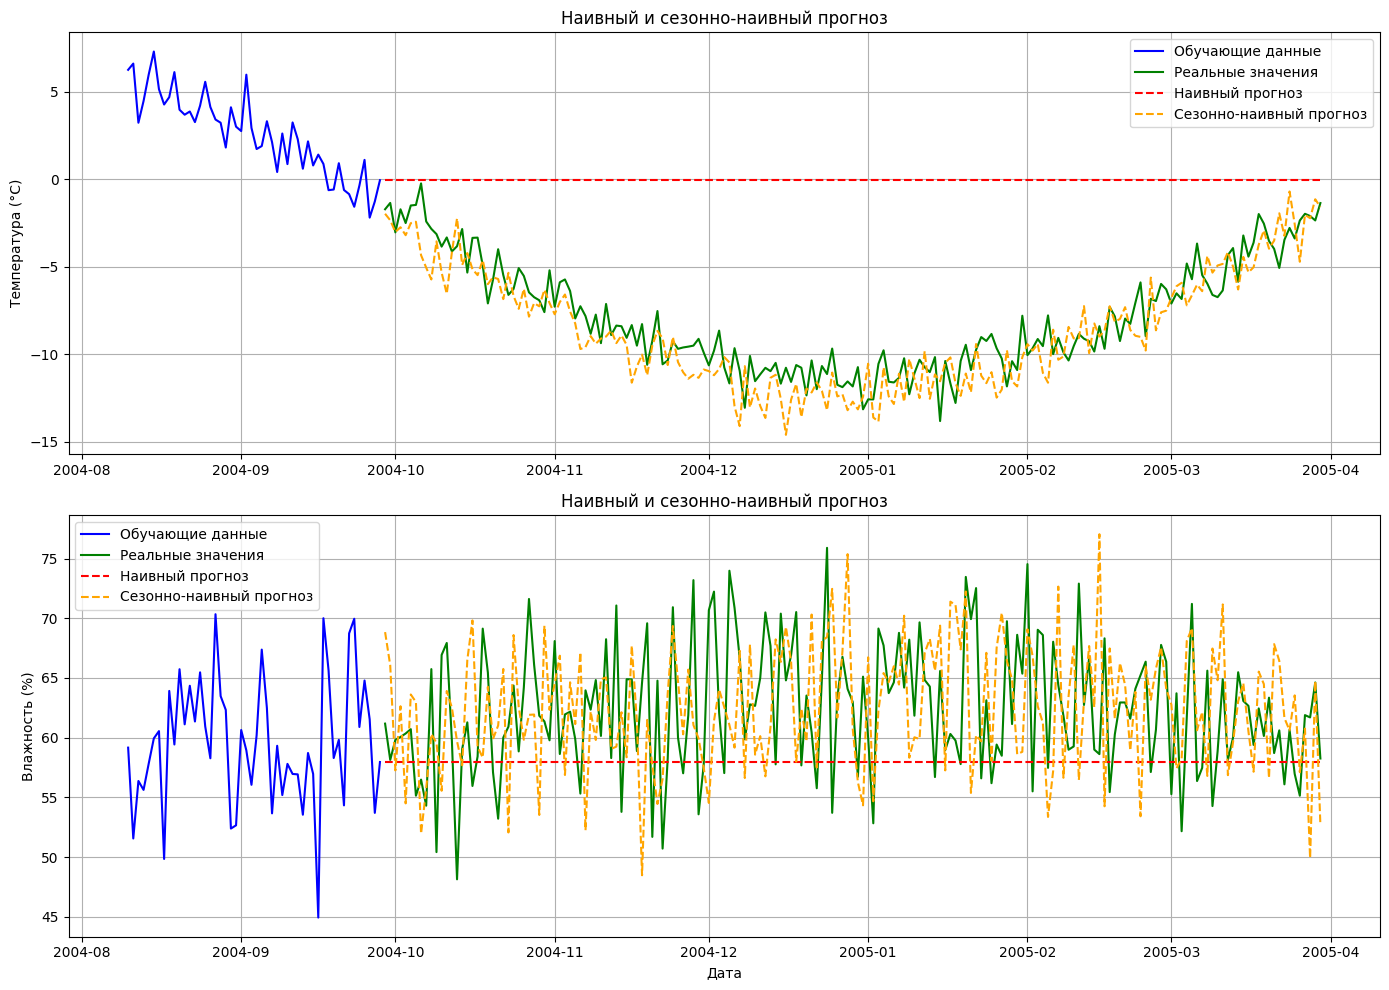

In [6]:
# Визуализация прогнозов температуры
plt.figure(figsize=(14, 10))

# График температуры
plt.subplot(2, 1, 1)
plt.plot(train.index[-50:], train['temperature'].iloc[-50:], label='Обучающие данные', color='blue')
plt.plot(test.index, test['temperature'], label='Реальные значения', color='green')
plt.plot(test.index, test['naive_temp'], label='Наивный прогноз', color='red', linestyle='--')
plt.plot(test.index, test['seasonal_naive_temp'], label='Сезонно-наивный прогноз', color='orange', linestyle='--')
plt.ylabel('Температура (°C)')
plt.title('Наивный и сезонно-наивный прогноз')
plt.legend()
plt.grid(True)

# График влажности
plt.subplot(2, 1, 2)
plt.plot(train.index[-50:], train['humidity'].iloc[-50:], label='Обучающие данные', color='blue')
plt.plot(test.index, test['humidity'], label='Реальные значения', color='green')
plt.plot(test.index, test['naive_humidity'], label='Наивный прогноз', color='red', linestyle='--')
plt.plot(test.index, test['seasonal_naive_humidity'], label='Сезонно-наивный прогноз', color='orange', linestyle='--')
plt.ylabel('Влажность (%)')
plt.xlabel('Дата')
plt.title('Наивный и сезонно-наивный прогноз')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Использование скользящего среднего

**Алгоритм скользящего среднего** — это простой статистический метод, используемый для анализа временных рядов, который позволяет сглаживать краткосрочные колебания и выделять долгосрочные тренды или циклические компоненты. Скользящее среднее вычисляется путем усреднения значений ряда за определенный период (окно), которое "скользит" вдоль временного ряда.

Преимущества:
- Простота реализации и понимания
- Эффективно сглаживает случайные колебания
- Хорошо работает для стационарных рядов
- Быстрое вычисление

Недостатки:
- Сильное запаздывание (лаг) относительно реальных данных
- Плохо реагирует на резкие изменения тренда
- Не учитывает сезонность
- Все точки в окне имеют одинаковую важность

### Пример

In [7]:
# Скользящее среднее с динамическим обновлением (окно 7 дней)
window_size = 7

# Прогноз на основе скользящего среднего с использованием расширяющегося окна
rolling_forecast_temp = []
rolling_forecast_humidity = []

# Создаем копии данных для динамического обновления
history_temp = train['temperature'].copy()
history_humidity = train['humidity'].copy()

for i in range(len(test)):
    # Для температуры: используем последние window_size дней из доступной истории
    if len(history_temp) >= window_size:
        temp_forecast = history_temp.iloc[-window_size:].mean()
    else:
        temp_forecast = history_temp.mean()
    
    # Для влажности: используем последние window_size дней из доступной истории
    if len(history_humidity) >= window_size:
        humidity_forecast = history_humidity.iloc[-window_size:].mean()
    else:
        humidity_forecast = history_humidity.mean()
    
    rolling_forecast_temp.append(temp_forecast)
    rolling_forecast_humidity.append(humidity_forecast)
    
    # Обновляем историю, добавляя текущий прогноз для следующей итерации
    # В реальном сценарии мы бы использовали фактические значения, но здесь используем прогноз
    history_temp = pd.concat([history_temp, pd.Series([temp_forecast])])
    history_humidity = pd.concat([history_humidity, pd.Series([humidity_forecast])])

# Добавляем прогнозы в test DataFrame
test['rolling_temp'] = rolling_forecast_temp
test['rolling_humidity'] = rolling_forecast_humidity

Описание:
- Задаем размер окна (`window_size = 7`).
- Создаем пустые списки для прогнозов температуры и влажности.
- Создаем копии исторических данных по температуре и влажности из тренировочного набора.
- Для каждого индекса в тестовом наборе (количество итераций равно длине тестового набора) выполняем:
    - Проверяем, что история по температуре имеет как минимум `window_size = 7` точек. Если да, то берем среднее последних `7` дней. Если нет, то среднее всей истории.
    - Аналогично для влажности.
    - Добавляем полученные прогнозы в списки `rolling_forecast_temp` и `rolling_forecast_humidity`.
    - Обновляем историю, добавляя в конец истории (и для температуры, и для влажности) только что сделанный прогноз.


**Важно!**
Алгоритм использует собственные прогнозы для расширения исторических данных вместо того, чтобы использовать реальные (фактические) значения.

Это не всегда походит:
- На каждом шаге прогноз делается на основе данных, которые уже содержат ошибки от предыдущих прогнозов. Это приводит к "дрейфу" прогноза, который со временем все больше отклоняется от реальности.

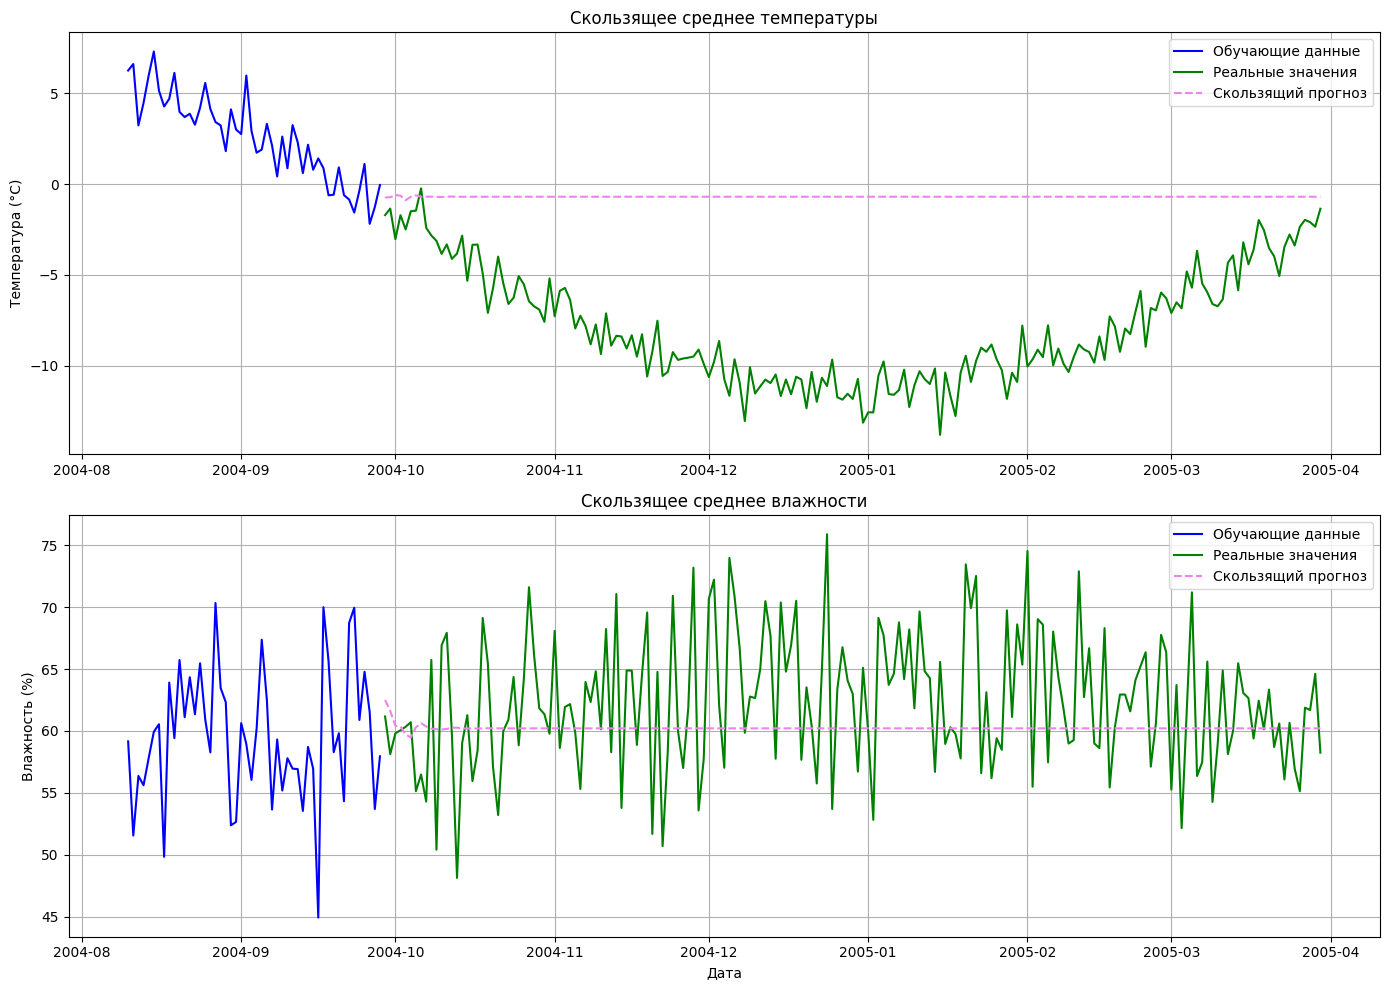

In [8]:
# Визуализация прогнозов температуры
plt.figure(figsize=(14, 10))

# График температуры
plt.subplot(2, 1, 1)
plt.plot(train.index[-50:], train['temperature'].iloc[-50:], label='Обучающие данные', color='blue')
plt.plot(test.index, test['temperature'], label='Реальные значения', color='green')
plt.plot(test.index, test['rolling_temp'], label='Скользящий прогноз', color='violet', linestyle='--')
plt.ylabel('Температура (°C)')
plt.title('Скользящее среднее температуры')
plt.legend()
plt.grid(True)

# График влажности
plt.subplot(2, 1, 2)
plt.plot(train.index[-50:], train['humidity'].iloc[-50:], label='Обучающие данные', color='blue')
plt.plot(test.index, test['humidity'], label='Реальные значения', color='green')
plt.plot(test.index, test['rolling_humidity'], label='Скользящий прогноз', color='violet', linestyle='--')
plt.ylabel('Влажность (%)')
plt.xlabel('Дата')
plt.title('Скользящее среднее влажности')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Визуализация и оценка качества наивных прогнозов

### Все подходы на одном графике

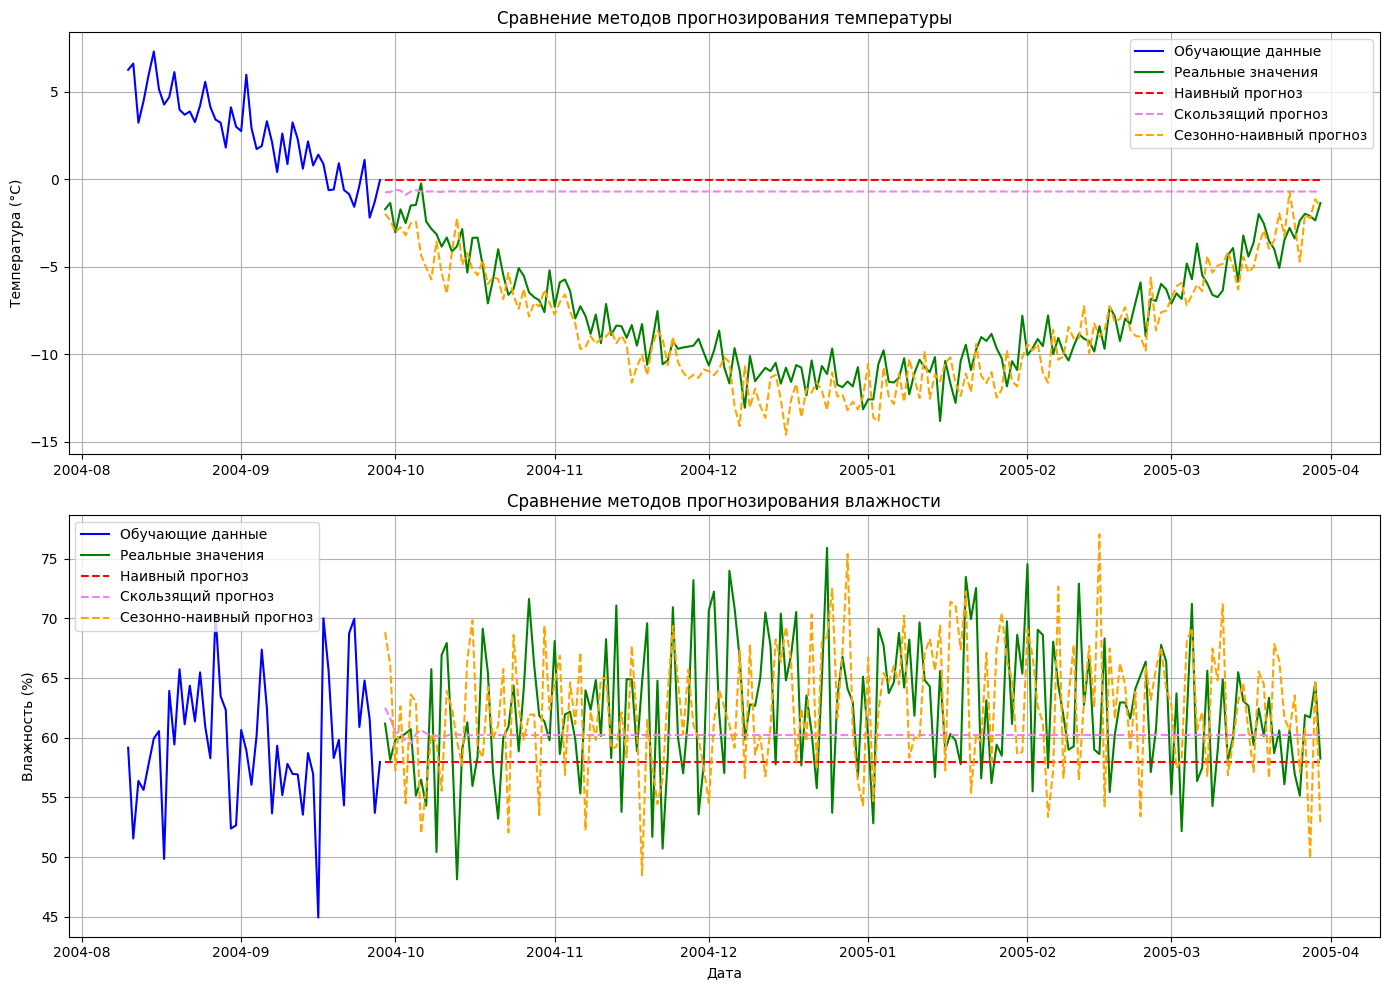

In [9]:
# Визуализация прогнозов температуры
plt.figure(figsize=(14, 10))

# График температуры
plt.subplot(2, 1, 1)
plt.plot(train.index[-50:], train['temperature'].iloc[-50:], label='Обучающие данные', color='blue')
plt.plot(test.index, test['temperature'], label='Реальные значения', color='green')
plt.plot(test.index, test['naive_temp'], label='Наивный прогноз', color='red', linestyle='--')
plt.plot(test.index, test['rolling_temp'], label='Скользящий прогноз', color='violet', linestyle='--')
plt.plot(test.index, test['seasonal_naive_temp'], label='Сезонно-наивный прогноз', color='orange', linestyle='--')
plt.ylabel('Температура (°C)')
plt.title('Сравнение методов прогнозирования температуры')
plt.legend()
plt.grid(True)

# График влажности
plt.subplot(2, 1, 2)
plt.plot(train.index[-50:], train['humidity'].iloc[-50:], label='Обучающие данные', color='blue')
plt.plot(test.index, test['humidity'], label='Реальные значения', color='green')
plt.plot(test.index, test['naive_humidity'], label='Наивный прогноз', color='red', linestyle='--')
plt.plot(test.index, test['rolling_humidity'], label='Скользящий прогноз', color='violet', linestyle='--')
plt.plot(test.index, test['seasonal_naive_humidity'], label='Сезонно-наивный прогноз', color='orange', linestyle='--')
plt.ylabel('Влажность (%)')
plt.xlabel('Дата')
plt.title('Сравнение методов прогнозирования влажности')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Расчет метрик качества

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_forecast(actual, forecast, name):
    mse = mean_squared_error(actual, forecast)
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mse)
    
    print(f'{name}:')
    print(f'  MSE: {mse:.2f}')
    print(f'  MAE: {mae:.2f}')
    print(f'  RMSE: {rmse:.2f}')

# Оценка прогнозов температуры
print('ОЦЕНКА КАЧЕСТВА ПРОГНОЗОВ ТЕМПЕРАТУРЫ:')
evaluate_forecast(test['temperature'], test['naive_temp'], 'Наивный метод')
evaluate_forecast(test['temperature'], test['seasonal_naive_temp'], 'Сезонно-наивный метод')
evaluate_forecast(test['temperature'], test['rolling_temp'], 'Скользящий метод')

print('\nОЦЕНКА КАЧЕСТВА ПРОГНОЗОВ ВЛАЖНОСТИ:')
evaluate_forecast(test['humidity'], test['naive_humidity'], 'Наивный метод')
evaluate_forecast(test['humidity'], test['seasonal_naive_humidity'], 'Сезонно-наивный метод')
evaluate_forecast(test['humidity'], test['rolling_humidity'], 'Скользящий метод')

ОЦЕНКА КАЧЕСТВА ПРОГНОЗОВ ТЕМПЕРАТУРЫ:
Наивный метод:
  MSE: 70.74
  MAE: 7.79
  RMSE: 8.41
Сезонно-наивный метод:
  MSE: 2.47
  MAE: 1.29
  RMSE: 1.57
Скользящий метод:
  MSE: 61.06
  MAE: 7.15
  RMSE: 7.81

ОЦЕНКА КАЧЕСТВА ПРОГНОЗОВ ВЛАЖНОСТИ:
Наивный метод:
  MSE: 48.08
  MAE: 5.52
  RMSE: 6.93
Сезонно-наивный метод:
  MSE: 51.75
  MAE: 5.86
  RMSE: 7.19
Скользящий метод:
  MSE: 33.46
  MAE: 4.59
  RMSE: 5.78


# Дополнительные темы для изучения

- **Модели ARIMA и SARIMA** $-$ классические методы для стационарных и сезонных рядов
- **Экспоненциальное сглаживание** $-$ популярный семейство методов прогнозирования
- **RNN, LSTM и GRU** $-$ более современные архитектуры рекуррентных сетей
- **Временные ряды в реальных приложениях** — прогнозирование спроса, финансовые прогнозы, анализ сенсорных данных